The prediction made in the previous section take into account uncertainties due to the fact that a Gaussian process
is stochastic but it doesn’t take into account any uncertainties in the values of the hyperparameters. 
This won’t matter if the hyperparameters are very well constrained by the data but in this case, 
many of the parameters are actually poorly constrained. To take this effect into account, 
we can apply prior probability functions to the hyperparameters and marginalize using Markov chain Monte Carlo (MCMC). 

In [10]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp, FitFunctionKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


In [11]:
xvalO = np.load("../GP_Paper/xvalO.npy")
yvalO = np.load("../GP_Paper/yvalO.npy")
xerrO = np.load("../GP_Paper/xerrO.npy")
xlowO = np.load("../GP_Paper/xlowO.npy")
xval = np.load("../GP_Paper/xval.npy")
yval = np.load("../GP_Paper/yval.npy")
xerr = np.load("../GP_Paper/xerr.npy")
smoothGPFit = np.load("../GP_Paper/initialGPfit.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

In [12]:
# function to display covariance matrices

def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        #ax2.plot(x, 2e6*np.exp(-(x/300)), c='g')
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

    '''
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    samples = np.random.multivariate_normal(modelMatrix[0], K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("X")
    '''


In [13]:

#background only plots
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  


    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
           # print nD, nB, pval, prob, zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) #/len(nB)
    return zvals, chi2

In [14]:
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)


In [15]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### fit function or curve kernels


In [16]:
def fit_gp_ff(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 1.
        init2 = np.random.random() * 1. 
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                   p0 = init0, p1 = init1, p2 = init2, 
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, limit_p0 = (0,10), 
                   limit_p1 = (0, 10), limit_p2 = (-10,0)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_ff:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, p0, p1, p2):
        kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf


def fit_gp_ff_mean(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 1.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1e1
        init4 = np.random.random() * 1e1
        init5 = np.random.random() * 1e1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                   p0 = init0, p1 = init1, p2 = init2, p0m = init3, p1m = init4, p2m = init5,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p0m = 1e-2, 
                   error_p1m = 1e-2, error_p2m = 1e-2, limit_p0 = (0,10), limit_p1 = (0, 10), 
                   limit_p2 = (-10,0), limit_p0m = (0,10), limit_p1m = (0, 10), 
                   limit_p2m = (-10,0)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_ff_mean:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, p0, p1, p2, p0m, p1m, p2m):
        kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0m,p1m,p2m), self.x, self.xerr))
        except:
            return np.inf
        
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr




In [20]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

In [17]:
lnProb = logLike_gp_ff(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_ff(100, lnProb)
p0, p1, p2 = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGP, covGP = gp.predict(yval, xvalO)

min LL 338.201243075
best fit vals (1.7707730135529687, 7.442980093142584, -4.7035518552888345)


(1000, 83)
(1000, 83)


/Users/Darren/miniconda2/lib/python2.7/site-packages/george-1.0.0.dev0-py2.7-macosx-10.7-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.


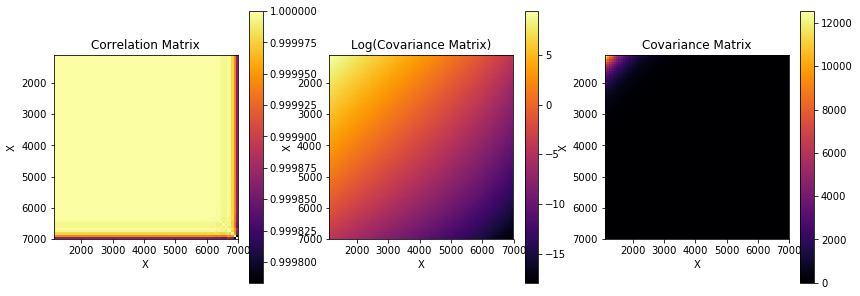

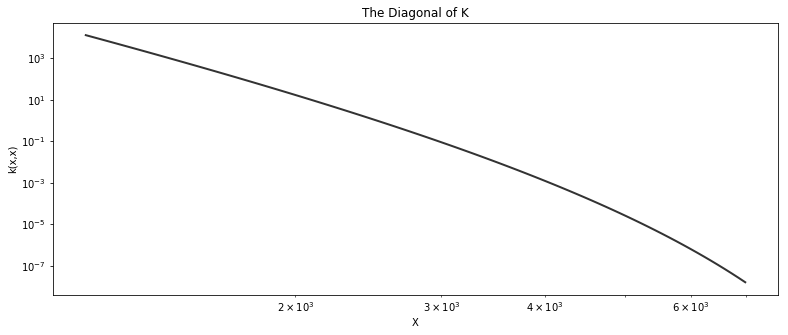

In [18]:
samps = gp.sample_conditional(yval, xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix[:100]).tolist(), "", ymax = 2e5)

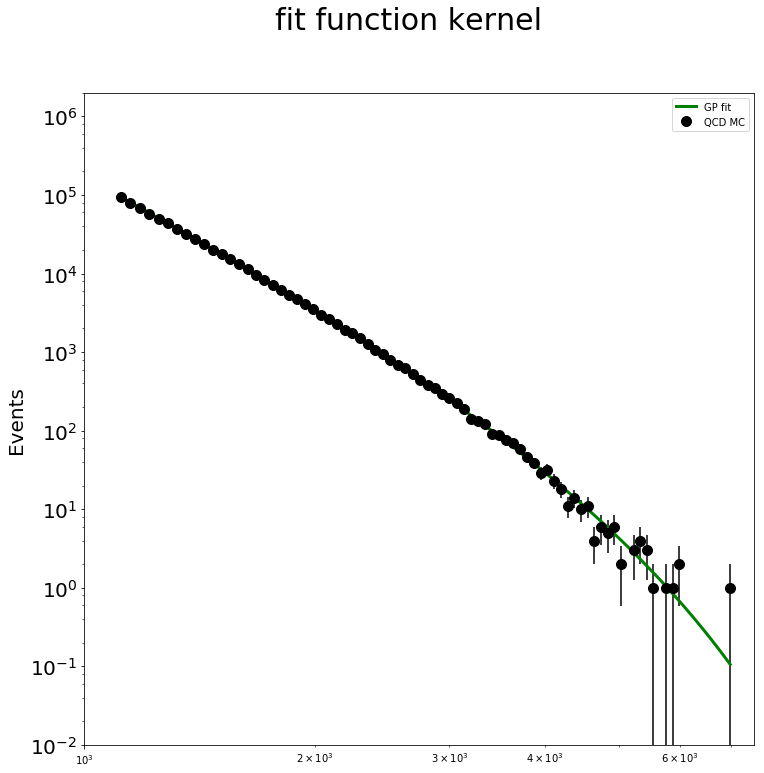

In [22]:
basicPlot(xvalO, yvalO, meanGP, "fit function kernel")
#makePrettyPlots(xvalO, yvalO, meanGP, "fit function kernel")

In [23]:
lnProb = logLike_gp_ff_mean(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_ff_mean(100, lnProb)
p0, p1, p2,p0m, p1m, p2m = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp((p0m,p1m,p2m),xval, xerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0m,p1m,p2m),xerrO)

min LL 310.696327105
best fit vals (1.2540091433588252e-05, 4.927644284624671, -1.4759517286156978, 0.016613550534080312, 8.46335966570054, -5.222525152078954)


(1000, 83)
(1000, 83)


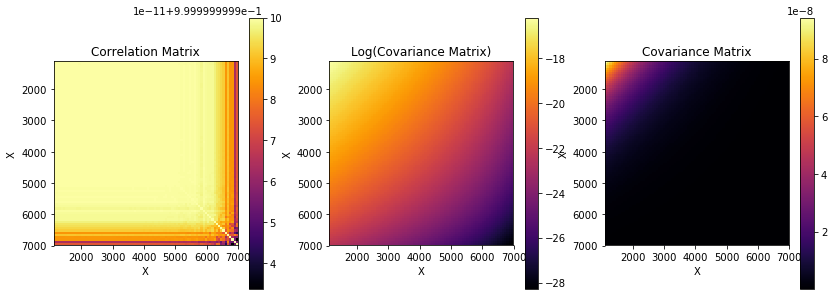

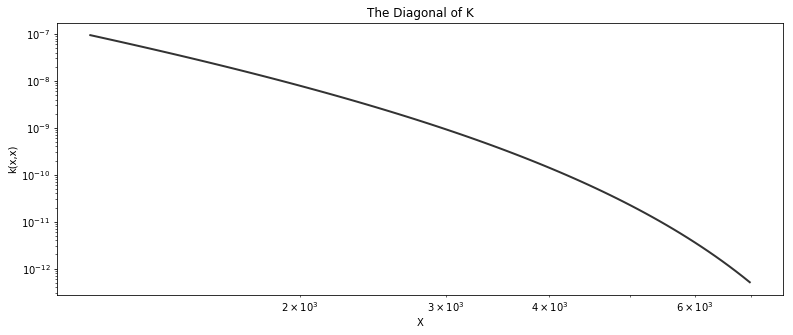

In [24]:
samps = gp.sample_conditional(yval - model_gp(best_fit_gp[3:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,best_fit_gp[3:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix[:100]).tolist(), "", ymax = 2e5)

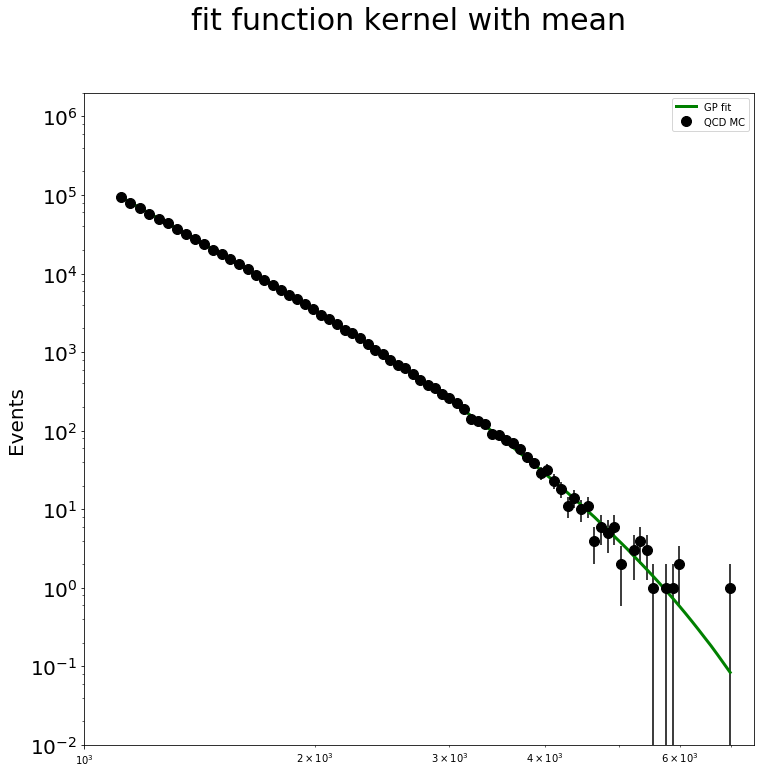

In [25]:
basicPlot(xvalO, yvalO, meanGP, "fit function kernel with mean")
#makePrettyPlots(xvalO, yvalO, meanGP, "fit function kernel with mean")

### other kernels at higher luminosity

In [26]:
highLum = makeToys(smoothGPFit, 5, 50)
ytoy, xtoy, xtoyerr = removeZeros(highLum[0])

min LL 769.602145867
best fit vals (9.999999999918023, 7.544149120051198, -4.691301057563183)


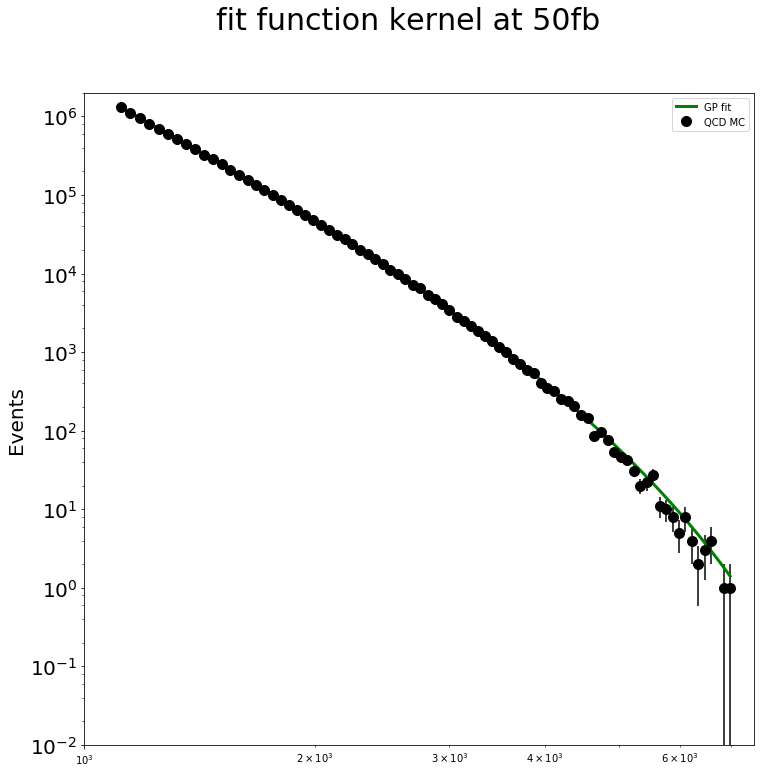

In [29]:
lnProb = logLike_gp_ff(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_ff(100, lnProb)
p0, p1, p2 = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGP, covGP = gp.predict(ytoy, xvalO)
basicPlot(xvalO, highLum[0], meanGP, "fit function kernel at 50fb")
#makePrettyPlots(xvalO, highLum[0], meanGP, "fit function kernel at 50fb", 'g', 10e6)

min LL 441.226447396
best fit vals (9.999053163063659, 4.456198823288467, -1.0015696915413912, 0.22956733940540097, 8.449741570959205, -5.224271378436551)


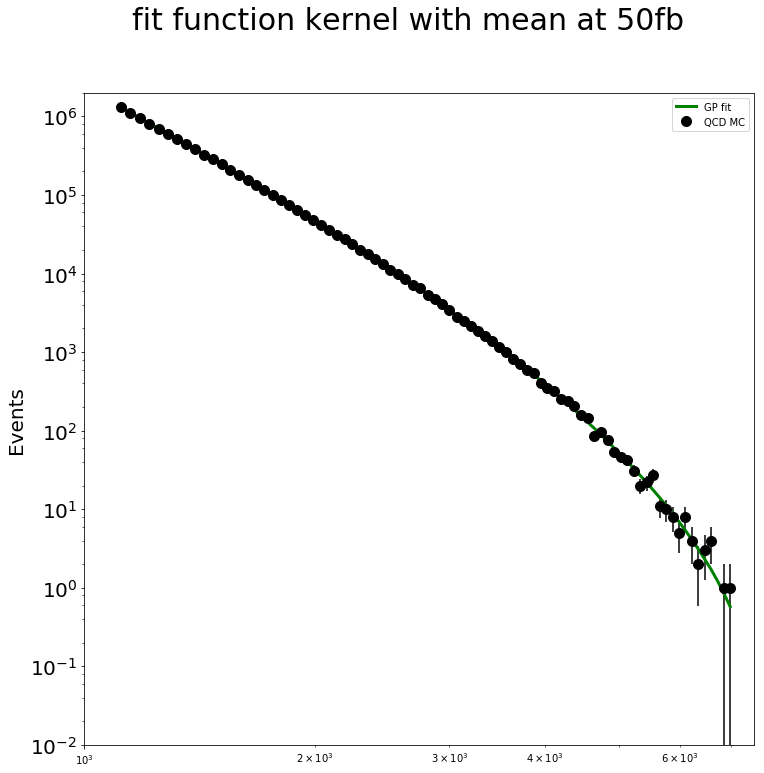

In [30]:
lnProb = logLike_gp_ff_mean(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_ff_mean(100, lnProb)
p0, p1, p2,p0m, p1m, p2m = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGPp, covGP = gp.predict(ytoy - model_gp((p0m,p1m,p2m),xtoy, xtoyerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0m,p1m,p2m),xerrO)
basicPlot(xvalO, highLum[0], meanGP, "fit function kernel with mean at 50fb")
#makePrettyPlots(xvalO, highLum[0], meanGP, "fit function kernel with mean at 50fb", 'g', 10e6)